In [1]:

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import os.path


def convert_local_time_and_reorder_for_time_hh_mm(data):
    """
    function to convert time array of diurnal cycle data from UTC to local time and reorder 
    data with respect to hh:mm, displaying diurnal cycle correctly.
    

    Args:
        data (xarray dataset): data to reorder
    Returns:
        data_sorted
    """
    data['Time'] = pd.to_datetime(data.Time.values) - timedelta(hours=4)
    times = pd.to_datetime(data.Time.values)
    times_hh = times.hour
    times_mm = times.minute
    num_times= np.arange(0,len(times_mm))
    times_new = ([datetime(2000,1,1,times_hh[i], times_mm[i]) for i in num_times])
    data['Time'] = times_new
    data_sorted = data.sortby('Time')
    
    return(data_sorted)



In [12]:
path_to_file = '/work/4sibylle/diurnal_cycle_arthus/5_mins/diurnal_cycle/'

def convert_local_time_and_reorder_for_time_hh_mm(data):
    """
    function to convert time array of diurnal cycle data from UTC to local time and reorder 
    data with respect to hh:mm, displaying diurnal cycle correctly.
    

    Args:
        data (xarray dataset): data to reorder
    Returns:
        data_sorted
    """
    data['Time'] = pd.to_datetime(data.Time.values) - timedelta(hours=4)
    times = pd.to_datetime(data.Time.values)
    times_hh = times.hour
    times_mm = times.minute
    num_times= np.arange(0,len(times_mm))
    times_new = ([datetime(2000,1,1,times_hh[i], times_mm[i]) for i in num_times])
    data['Time'] = times_new
    data_sorted = data.sortby('Time')
    
    return(data_sorted)


def read_all_lidar_diurnal_cycle_files(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    T_data = xr.open_dataset(path_to_file+'T_diurnal_cycle.nc')
    MR_data = xr.open_dataset(path_to_file+'MR_diurnal_cycle.nc')
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')
    VW_data = xr.open_dataset(path_to_file+'VW_diurnal_cycle.nc')
    H_wind_data = xr.open_dataset(path_to_file+'H_wind_speed_diurnal_cycle.nc')

    data_array = [T_data, MR_data, VW_data, H_wind_data, LHF_data, SHF_data, ]

    # convert time to local time (UTC - 4)
    data_lt = []
    for i, data in enumerate(data_array):
        data_lt.append(convert_local_time_and_reorder_for_time_hh_mm(data))
        
    return(data_lt)



def read_all_lidar_diurnal_cycle_files_2(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    T_data = xr.open_dataset(path_to_file+'T_diurnal_cycle.nc')
    MR_data = xr.open_dataset(path_to_file+'MR_diurnal_cycle.nc')
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')
    VW_data = xr.open_dataset(path_to_file+'VW_diurnal_cycle.nc')
    H_wind_data = xr.open_dataset(path_to_file+'H_wind_speed_diurnal_cycle.nc')

    data_array = [T_data, MR_data, VW_data, H_wind_data]
    var_list = ['T','MR','VW', 'HW']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name})
        data_lt.append(data_new)
        
    data_out = xr.merge(data_lt)
    return(data_out)

#data = read_all_lidar_diurnal_cycle_files_2(path_to_file)


def read_fluxes(path_to_file):
    """function to read all lidar diurnal cycle files and 
    convert them to local time 
    
    arguments:
    path_to_file: string, path to the file directory
    dependencies:
    
    convert_local_time_and_reorder_for_time_hh_mm
    
    returns (list of xarray dataset)
    """
    LHF_data = xr.open_dataset(path_to_file+'LHF_diurnal_cycle.nc')
    SHF_data = xr.open_dataset(path_to_file+'SHF_diurnal_cycle.nc')

    data_array = [ LHF_data, SHF_data]
    var_list = [ 'LHF', 'SHF']
    # convert time to local time (UTC - 4)
    data_lt = []
    
    for i, data in enumerate(data_array):
        var_name = var_list[i]
        data_new = convert_local_time_and_reorder_for_time_hh_mm(data)
        data_new = data_new.rename({'diurnal_cycle':var_name})
        data_lt.append(data_new)

    data_out = xr.merge(data_lt, join='inner', )
    return()

data = read_all_lidar_diurnal_cycle_files_2(path_to_file)
fluxes = read_fluxes(path_to_file)
print(data)

<xarray.Dataset>
Dimensions:  (Time: 96, Height: 457)
Coordinates:
  * Time     (Time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:45:00
  * Height   (Height) float64 0.0 21.21 42.42 ... 8.42e+03 8.442e+03 8.463e+03
Data variables:
    T        (Time, Height) float32 nan nan nan nan nan ... nan nan nan nan nan
    MR       (Time, Height) float32 nan nan nan nan nan ... nan nan nan nan nan
    VW       (Time, Height) float32 nan nan nan nan nan ... nan nan nan nan nan
    HW       (Time, Height) float64 4.052 5.825 8.976 9.169 ... nan nan nan nan
Attributes: (12/14)
    CREATED_BY:          Claudia Acquistapace
    CREATED_ON:          2024-08-19 13:16:05.541536
    FILL_VALUE:          NaN
    AUTHOR_NAME:         Claudia Acquistapace
    AUTHOR_AFFILIATION:  University of Cologne (UNI), Germany
    AUTHOR_ADDRESS:      Institute for geophysics and meteorology, Pohligstra...
    ...                  ...
    DATA_DISCIPLINE:     Atmospheric Physics - Remote Sensing Lidar Profiler
    DA

0
T [K]


NameError: name 'data_lt' is not defined

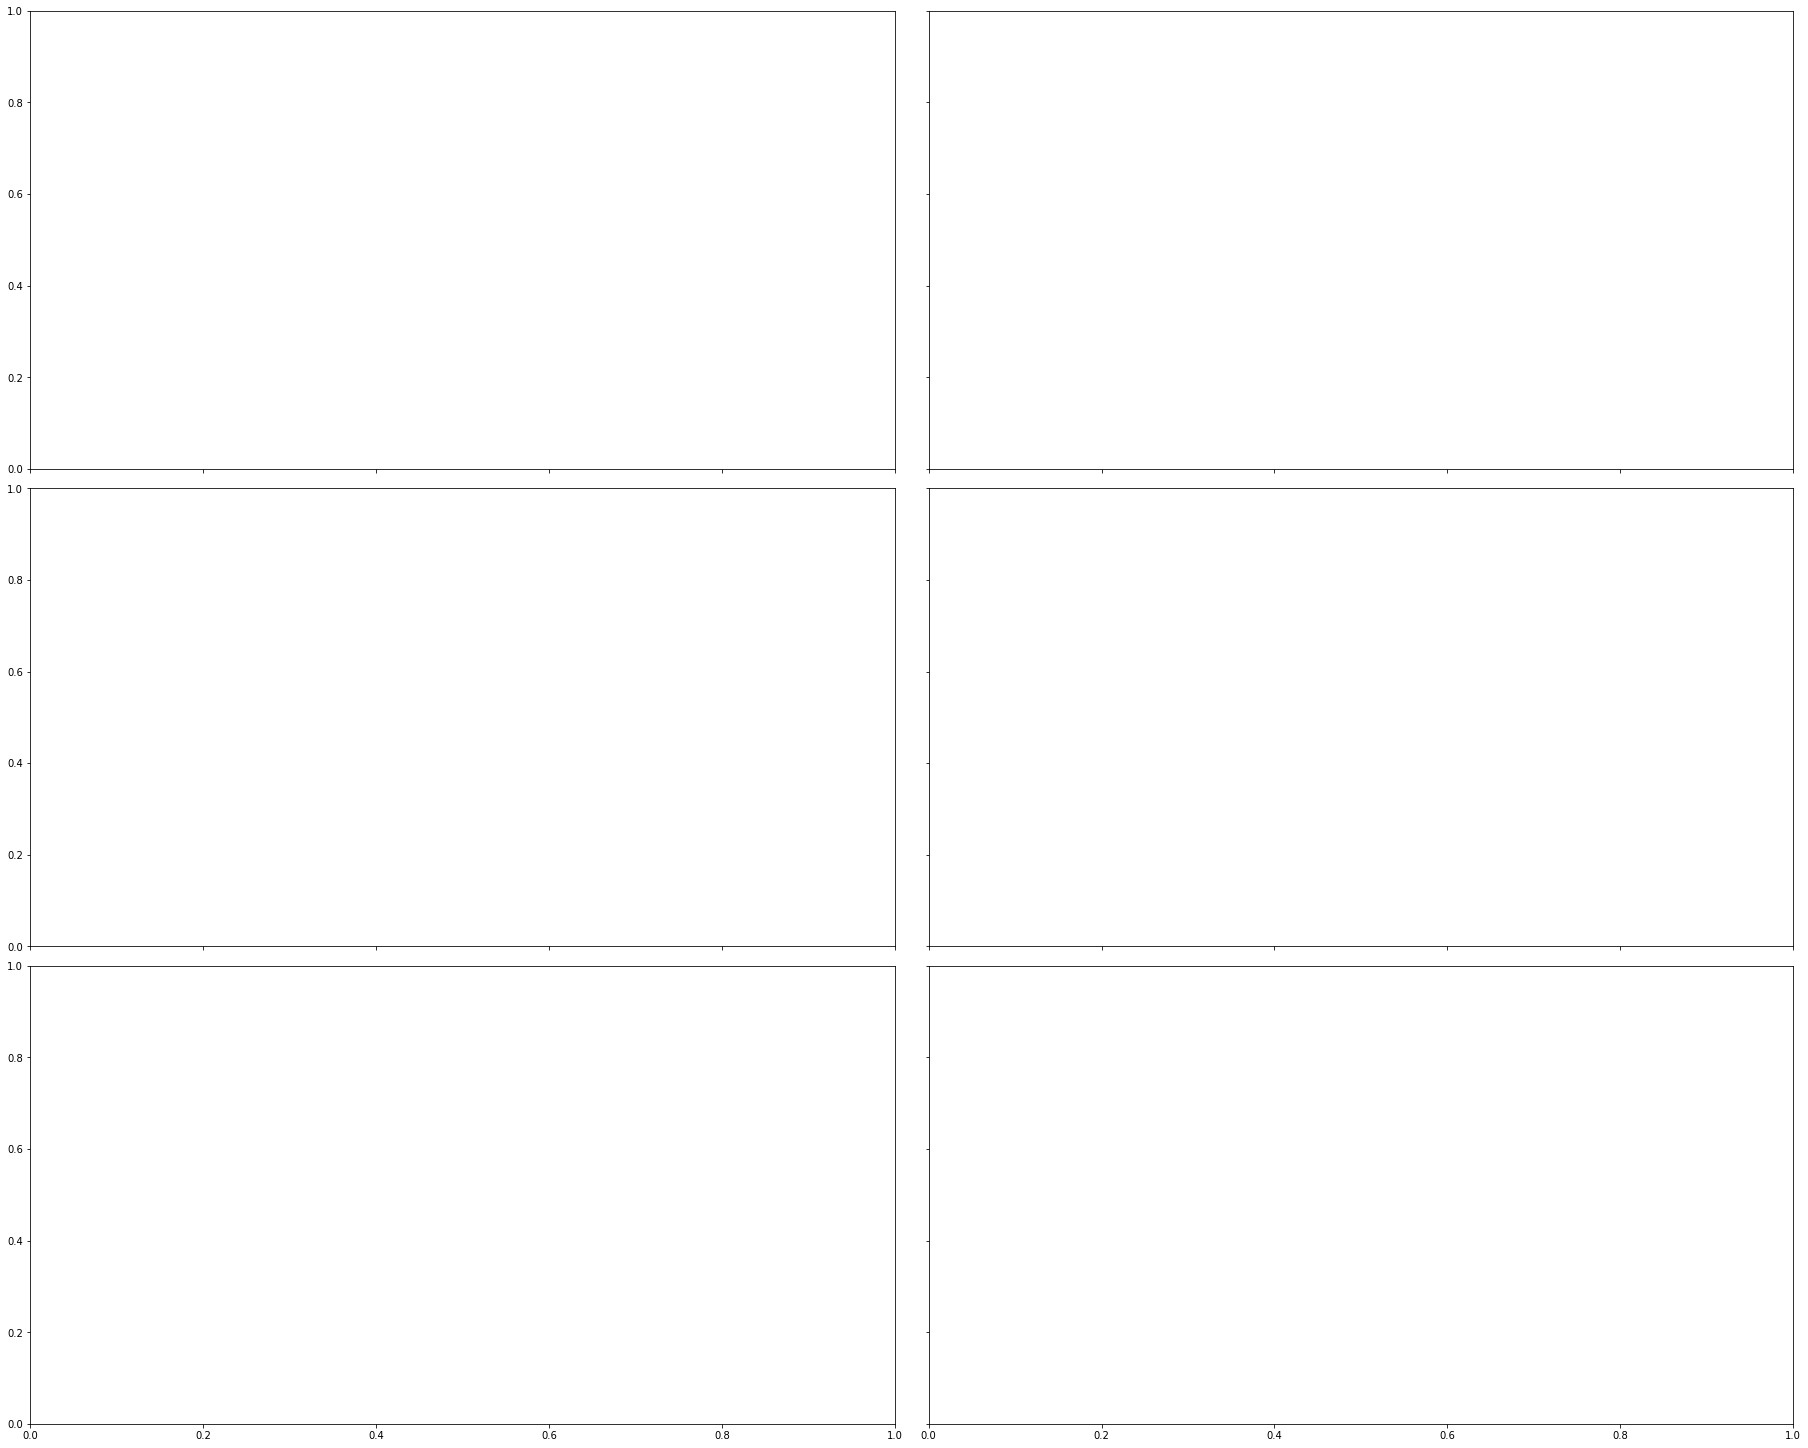

In [6]:
 # plot diurnal cycle 
 
 units_arr = ['T [K]', 
             'MR [gm$^{-2}$]', 
             'W [ms$^{-1}$]',
             'u$^2$+v$^2$ [ms$^{-1}$]',
             'LHF [Wm$^{-2}$]', 
             'SHF [Wm$^{-2}$]']
vmin_arr = [290,
            10,
            -1,
            6,
            -30,
            -20,]
vmax_arr = [300, 
            16, 
            1, 
            10,
            100,
            20,
            ]
 
fig2, axs = plt.subplots(3,2, figsize=(25,20), sharex=True, sharey=True, constrained_layout=True)

ind_dataset = 0
for i in range(0,3):
    for j in range(0,2):
        print(ind_dataset)
        print(units_arr[ind_dataset])
        # reading input data
        data = data_lt[ind_dataset]
                
        # plot map of the variable
        mesh = axs[i,j].pcolormesh(data['Time'].values, 
                            data['Height'].values,
                            data['diurnal_cycle'].values.T,
                            cmap='viridis',
                            vmin=vmin_arr[ind_dataset], 
                            vmax=vmax_arr[ind_dataset],
                            rasterized=True)
        cbar = fig2.colorbar(mesh, location='right', aspect=20)
        
        cbar.ax.tick_params(labelsize=20)
        cbar.ax.set_title(label=units_arr[ind_dataset],fontsize=20)
        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)
        axs[i,j].spines["bottom"].set_linewidth(3)
        axs[i,j].spines["left"].set_linewidth(3)
        #axs[i,j].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        #axs[i,j].tick_params(which='minor', length=5, width=2, labelsize = 5)
        #axs[i,j].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
        axs[i,j].tick_params(axis='both', labelsize=20)
        axs[i,j].get_xaxis().tick_bottom()
        axs[i,j].get_yaxis().tick_left()
        axs[i,j].set_ylim(200.,1500.)
        axs[i,j].set_xlim(data.Time.values[0],data.Time.values[-1])

        axs[2,j].set_xlabel('Local time [UTC-4]', fontsize=20)
        axs[i,j].set_ylabel('Height [m]', fontsize=20)
        axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

        ind_dataset = ind_dataset+1



for ax, l in zip(axs[:,:].flatten(), ['a) Temperature', 
                                      'b) Mixing ratio',
                                      'c) Vertical velocity',
                                      'd) Horizontal wind speed', 
                                      'e) Latent heat flux', 
                                      'f) Sensible heat flux']):
    ax.text(-0.05, 1.07, l,  fontweight='black', fontsize=25, transform=ax.transAxes)
    
fig2.savefig(
os.path.join('/work/4sibylle/diurnal_cycle_arthus/5_mins/plots/', 'diurnal_cycle_overview.png'),
dpi=300,
bbox_inches="tight",
transparent=True,   
)
plt.close()